# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import os
city = os.getenv("CITY", "moirana")  # default
print("Running pipeline for:", city)

Running pipeline for: moirana


In [2]:
import sys
from pathlib import Path

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
#settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: c:\Users\lulev\Desktop\KTH\mlfs-book


In [3]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util
import os

In [4]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 17, 14, 4, 21, 589650)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [5]:
project = hopsworks.login(engine="python")
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret(f"SENSOR_LOCATION_JSON_{city}").value
param = json.loads(location_str)

2025-11-17 14:04:24,175 INFO: Initializing external client
2025-11-17 14:04:24,178 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-17 14:04:25,213 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-17 14:04:26,115 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1279155


In [6]:
param

{'url': 'https://api.waqi.info/feed/@12698',
 'csv_file': 'c:\\Users\\lulev\\Desktop\\KTH\\mlfs-book/data/moirana.csv',
 'latitude': 66.33,
 'longitude': 14.18}

## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [7]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name=f"air_quality_xgboost_model_{city}",
    version=4,
)

fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

2025-11-17 14:04:34,861 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/508117 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/434238 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/84702 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/100758 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26588 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/516879 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/523306 elapsed<00:00 remaining<?

In [8]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_model = XGBRegressor()

retrieved_model.load_model(saved_model_dir + f"/{city}_model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_model

XGBRegressor(base_score='2.4848E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [9]:
weather_fg = fs.get_feature_group(
    name=f'weather_{city}',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.58s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2025-11-23 00:00:00+00:00,2.15,0.1,2.968636,75.963730,moirana
1,2025-11-21 00:00:00+00:00,-7.75,0.0,3.706427,29.054508,moirana
2,2025-11-20 00:00:00+00:00,-12.90,0.0,0.360000,90.000000,moirana
3,2025-11-18 00:00:00+00:00,-4.25,0.0,2.902413,29.744795,moirana
4,2025-11-22 00:00:00+00:00,-7.40,0.1,4.693826,57.528828,moirana
5,2025-11-19 00:00:00+00:00,-11.40,0.0,0.509117,44.999897,moirana


In [10]:
yesterday = pd.Timestamp(today - datetime.timedelta(days=1), tz="UTC")
air_quality_fg = fs.get_feature_group(
    f'air_quality_{city}',
    version=1,
)
df_today = air_quality_fg.filter(air_quality_fg.date >= yesterday).read()
df_today

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.80s) 


,date,pm25,city,url,lag1,lag2,lag3,rolling
0,2025-11-17 00:00:00+00:00,9.0,moirana,https://api.waqi.info/feed/@12698,27.0,4.0,12.0,14.333333


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [11]:
import numpy as np

feature_weather = [
    "temperature_2m_mean",
    "precipitation_sum",
    "wind_speed_10m_max",
    "wind_direction_10m_dominant",
]
feature_lags = ["lag1", "lag2", "lag3", "rolling"]
feature_cols = feature_lags + feature_weather

# Initial features
lag1 = float(df_today["pm25"].iloc[0])
lag2 = float(df_today["lag1"].iloc[0])
lag3 = float(df_today["lag2"].iloc[0])
rolling = float(np.nanmean([lag1, lag2, lag3]))

# Prepare columns
batch_data["lag1"] = np.nan
batch_data["lag2"] = np.nan
batch_data["lag3"] = np.nan
batch_data["rolling"] = np.nan
batch_data["predicted_pm25"] = np.nan

for idx, row in batch_data.iterrows():
    # Set lag features for this forecast day
    batch_data.at[idx, "lag1"] = lag1
    batch_data.at[idx, "lag2"] = lag2
    batch_data.at[idx, "lag3"] = lag3
    batch_data.at[idx, "rolling"] = rolling

    # Build feature vector for this day
    X_row = batch_data.loc[idx, feature_cols].astype(float).to_frame().T

    # Predict pm25 for this day
    y_hat = retrieved_model.predict(X_row)[0]
    batch_data.at[idx, "predicted_pm25"] = y_hat

    # Autoregressive step
    lag3 = lag2
    lag2 = lag1
    lag1 = y_hat
    rolling = np.nanmean([lag1, lag2, lag3])
batch_data[["lag1", "lag2", "lag3", "rolling", "predicted_pm25"]] = (
    batch_data[["lag1", "lag2", "lag3", "rolling", "predicted_pm25"]].astype("float32")
)
batch_data


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,lag1,lag2,lag3,rolling,predicted_pm25
0,2025-11-23 00:00:00+00:00,2.15,0.1,2.968636,75.963730,moirana,9.000000,27.000000,4.000000,13.333333,17.187122
1,2025-11-21 00:00:00+00:00,-7.75,0.0,3.706427,29.054508,moirana,17.187122,9.000000,27.000000,17.729040,39.228138
2,2025-11-20 00:00:00+00:00,-12.90,0.0,0.360000,90.000000,moirana,39.228138,17.187122,9.000000,21.805086,56.964077
3,2025-11-18 00:00:00+00:00,-4.25,0.0,2.902413,29.744795,moirana,56.964077,39.228138,17.187122,37.793110,50.226414
4,2025-11-22 00:00:00+00:00,-7.40,0.1,4.693826,57.528828,moirana,50.226414,56.964077,39.228138,48.806210,43.310093
5,2025-11-19 00:00:00+00:00,-11.40,0.0,0.509117,44.999897,moirana,43.310093,50.226414,56.964077,50.166859,55.038136


In [12]:
# # MAKE A LOOP THAT PREDICTS FOR THE COMING DAY AND THEN USES THAT PREDICTION AS THE NEW
# # UPDATED LAG and ROLLING next day and so on...
# # batch_data has all the weather data for each of the 6 days to be predicted.
# batch_data['predicted_pm25'] = retrieved_model.predict(
#     batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
# batch_data

In [12]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         6 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          6 non-null      float32                
 2   precipitation_sum            6 non-null      float32                
 3   wind_speed_10m_max           6 non-null      float32                
 4   wind_direction_10m_dominant  6 non-null      float32                
 5   city                         6 non-null      object                 
 6   lag1                         6 non-null      float32                
 7   lag2                         6 non-null      float32                
 8   lag3                         6 non-null      float32                
 9   rolling                      6 non-null      float32                
 10  predic

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [13]:
batch_data['city'] = city
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data = batch_data.sort_values(by=['date'])
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,lag1,lag2,lag3,rolling,predicted_pm25,days_before_forecast_day
3,2025-11-18 00:00:00+00:00,-4.25,0.0,2.902413,29.744795,moirana,56.964077,39.228138,17.187122,37.793110,50.226414,1
5,2025-11-19 00:00:00+00:00,-11.40,0.0,0.509117,44.999897,moirana,43.310093,50.226414,56.964077,50.166859,55.038136,2
2,2025-11-20 00:00:00+00:00,-12.90,0.0,0.360000,90.000000,moirana,39.228138,17.187122,9.000000,21.805086,56.964077,3
1,2025-11-21 00:00:00+00:00,-7.75,0.0,3.706427,29.054508,moirana,17.187122,9.000000,27.000000,17.729040,39.228138,4
4,2025-11-22 00:00:00+00:00,-7.40,0.1,4.693826,57.528828,moirana,50.226414,56.964077,39.228138,48.806210,43.310093,5
0,2025-11-23 00:00:00+00:00,2.15,0.1,2.968636,75.963730,moirana,9.000000,27.000000,4.000000,13.333333,17.187122,6


In [14]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6 entries, 3 to 0
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         6 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          6 non-null      float32                
 2   precipitation_sum            6 non-null      float32                
 3   wind_speed_10m_max           6 non-null      float32                
 4   wind_direction_10m_dominant  6 non-null      float32                
 5   city                         6 non-null      object                 
 6   lag1                         6 non-null      float32                
 7   lag2                         6 non-null      float32                
 8   lag3                         6 non-null      float32                
 9   rolling                      6 non-null      float32                
 10  predicted_p

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

In [15]:
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,lag1,lag2,lag3,rolling,predicted_pm25,days_before_forecast_day
3,2025-11-18 00:00:00+00:00,-4.25,0.0,2.902413,29.744795,moirana,56.964077,39.228138,17.187122,37.793110,50.226414,1
5,2025-11-19 00:00:00+00:00,-11.40,0.0,0.509117,44.999897,moirana,43.310093,50.226414,56.964077,50.166859,55.038136,2
2,2025-11-20 00:00:00+00:00,-12.90,0.0,0.360000,90.000000,moirana,39.228138,17.187122,9.000000,21.805086,56.964077,3
1,2025-11-21 00:00:00+00:00,-7.75,0.0,3.706427,29.054508,moirana,17.187122,9.000000,27.000000,17.729040,39.228138,4
4,2025-11-22 00:00:00+00:00,-7.40,0.1,4.693826,57.528828,moirana,50.226414,56.964077,39.228138,48.806210,43.310093,5
0,2025-11-23 00:00:00+00:00,2.15,0.1,2.968636,75.963730,moirana,9.000000,27.000000,4.000000,13.333333,17.187122,6


2025-11-17 14:05:21,412 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



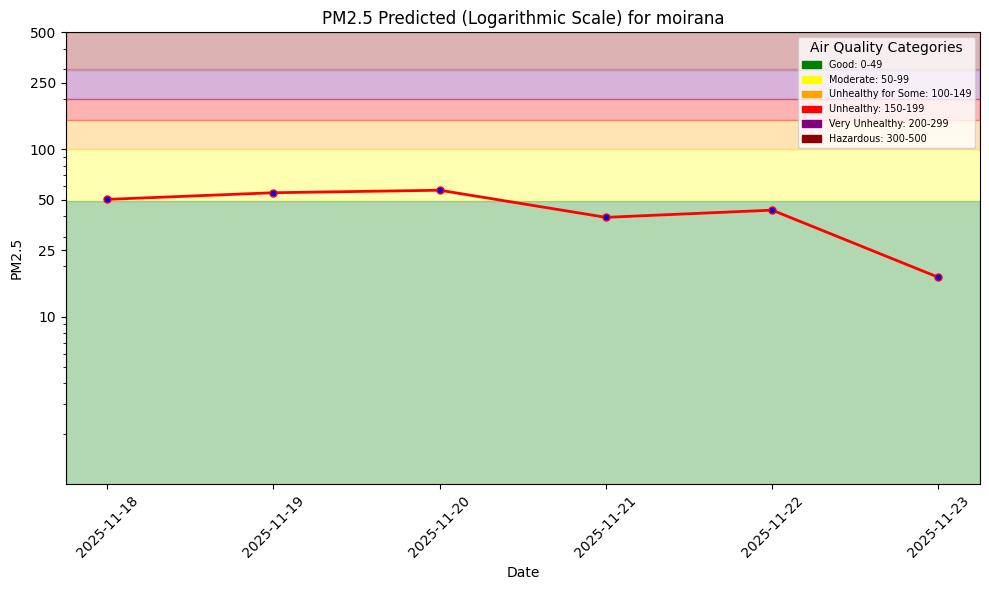

In [16]:
pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast_{city}.png"
plt = util.plot_air_quality_forecast(city, batch_data, pred_file_path)

plt.show()

In [17]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name=f'aq_predictions_{city}',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','date','days_before_forecast_day'],
    event_time="date"
)

In [19]:
monitor_fg.insert(batch_data, wait=True)

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1279155/fs/1265766/fg/1730921


Uploading Dataframe: 100.00% |██████████| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_moirana_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1279155/jobs/named/aq_predictions_moirana_1_offline_fg_materialization/executions
2025-11-17 13:57:16,751 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-17 13:57:19,965 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-17 13:59:11,932 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-17 13:59:12,096 INFO: Waiting for log aggregation to finish.
2025-11-17 13:59:34,486 INFO: Execution finished successfully.


(Job('aq_predictions_moirana_1_offline_fg_materialization', 'SPARK'), None)

In [18]:
# We will create a hindcast chart for only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.73s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,lag1,lag2,lag3,rolling,predicted_pm25,days_before_forecast_day
0,2025-11-18 00:00:00+00:00,-4.250000,0.000000,2.902413,29.744795,moirana,56.964077,39.228138,17.187122,37.793110,50.226414,1
1,2025-11-08 00:00:00+00:00,0.627083,0.100000,6.341009,43.919155,moirana,19.000000,4.000000,14.000000,12.333333,32.755394,1
2,2025-11-12 00:00:00+00:00,0.125000,8.400001,6.877789,39.414661,moirana,31.000000,50.000000,53.000000,44.666668,22.148935,1
3,2025-10-28 00:00:00+00:00,4.083333,4.200000,8.827343,35.203384,moirana,49.000000,21.000000,27.000000,32.333332,34.749256,1
4,2025-11-04 00:00:00+00:00,3.579167,13.500000,11.666721,19.354725,moirana,14.000000,15.000000,14.000000,14.333333,22.479612,1
5,2025-10-17 00:00:00+00:00,2.229167,4.800000,9.541698,215.167694,moirana,10.000000,9.000000,9.000000,9.333333,11.097459,1
6,2025-10-29 00:00:00+00:00,4.027083,3.500000,4.711051,49.686008,moirana,34.000000,49.000000,21.000000,34.666668,25.058559,1
7,2025-11-09 00:00:00+00:00,-0.254167,0.000000,7.748368,225.286942,moirana,16.000000,19.000000,4.000000,13.000000,26.854202,1
8,2025-11-16 00:00:00+00:00,-2.968750,6.300000,4.500000,61.355904,moirana,4.000000,12.000000,11.000000,9.000000,32.321198,1
9,2025-10-21 00:00:00+00:00,3.704167,0.400000,12.092196,38.304317,moirana,13.000000,6.000000,6.000000,8.333333,22.191923,1


In [19]:
air_quality_fg = fs.get_feature_group(name=f'air_quality_{city}', version=1)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.12s) 


,date,pm25,city,url,lag1,lag2,lag3,rolling
0,2022-12-03 00:00:00+00:00,44.0,moirana,https://api.waqi.info/feed/@12698,46.0,36.0,37.0,39.666668
1,2021-05-02 00:00:00+00:00,7.0,moirana,https://api.waqi.info/feed/@12698,7.0,13.0,14.0,11.333333
2,2024-12-21 00:00:00+00:00,53.0,moirana,https://api.waqi.info/feed/@12698,55.0,32.0,20.0,35.666668
3,2023-05-08 00:00:00+00:00,29.0,moirana,https://api.waqi.info/feed/@12698,26.0,32.0,35.0,31.000000
4,2022-09-01 00:00:00+00:00,15.0,moirana,https://api.waqi.info/feed/@12698,3.0,5.0,4.0,4.000000
...,...,...,...,...,...,...,...,...
2087,2023-09-01 00:00:00+00:00,15.0,moirana,https://api.waqi.info/feed/@12698,15.0,18.0,18.0,17.000000
2088,2025-11-14 00:00:00+00:00,12.0,moirana,https://api.waqi.info/feed/@12698,11.0,46.0,31.0,29.333334
2089,2021-11-05 00:00:00+00:00,29.0,moirana,https://api.waqi.info/feed/@12698,34.0,74.0,26.0,44.666668
2090,2025-02-01 00:00:00+00:00,34.0,moirana,https://api.waqi.info/feed/@12698,7.0,17.0,32.0,18.666666


In [20]:
from mlfs.airquality import util
outcome_df = air_quality_df[['date', 'pm25', 'city']]
preds_df =  monitoring_df[['date', 'predicted_pm25', 'city']]

hindcast_df = pd.merge(preds_df, outcome_df, on=["date","city"])
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_fg, monitor_fg, retrieved_model)
hindcast_df

,date,predicted_pm25,city,pm25
23,2025-10-15 00:00:00+00:00,12.482188,moirana,9.0
29,2025-10-16 00:00:00+00:00,9.896341,moirana,10.0
4,2025-10-17 00:00:00+00:00,11.097459,moirana,5.0
24,2025-10-18 00:00:00+00:00,12.339825,moirana,6.0
25,2025-10-19 00:00:00+00:00,12.225976,moirana,6.0
26,2025-10-20 00:00:00+00:00,19.186346,moirana,13.0
8,2025-10-21 00:00:00+00:00,22.191923,moirana,24.0
21,2025-10-22 00:00:00+00:00,17.465166,moirana,20.0
19,2025-10-23 00:00:00+00:00,15.854553,moirana,19.0
9,2025-10-24 00:00:00+00:00,19.161612,moirana,29.0


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

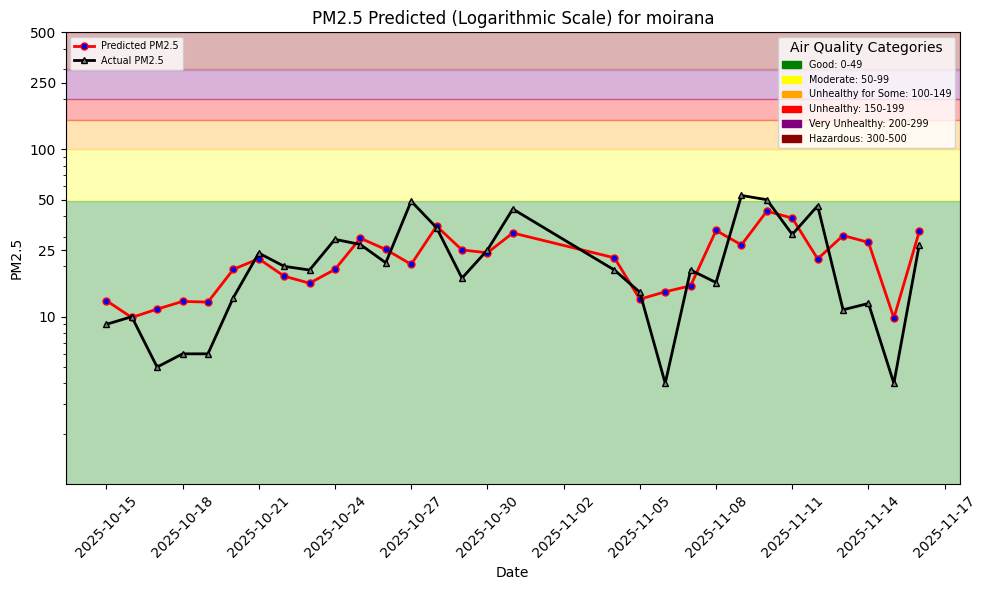

In [21]:
hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day_{city}.png"
util.plot_air_quality_forecast(city, hindcast_df, hindcast_file_path, hindcast=True)
plt.show()

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [22]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")
dataset_api.upload(f"{root_dir}/docs/air-quality/assets/img/pm25_forecast_{city}.png", f"Resources/airquality/{city}_{str_today}", overwrite=True)
dataset_api.upload(f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day_{city}.png", f"Resources/airquality/{city}_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

Uploading c:\Users\lulev\Desktop\KTH\mlfs-book/docs/air-quality/assets/img/pm25_forecast_moirana.png: 0.000%| …

Uploading c:\Users\lulev\Desktop\KTH\mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1day_moirana.png: 0.0…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1279155/settings/fb/path/Resources/airquality


---